In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [1]:
from tsnecuda import TSNE
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor, as_completed

def load_embeddings_v2(
    emb_path: str,
    file_list: list,
    meta_df: pd.DataFrame,
    query: str = None,
    num_workers: int = 4,
    label_col: str = "final_noise_type"  # <- 기본 라벨 컬럼을 final_noise_type으로
):
    """
    Load embeddings from a list of files in parallel with optional filtering by query.

    Args:
        emb_path (str): Path to the embeddings directory.
        file_list (list): List of files to load. Each file should be a .npy file.
        meta_df (pd.DataFrame): Metadata DataFrame. Columns must include 'hash' and label_col.
        query (str, optional): Query string to filter metadata. Example: "subset=='dev'".
        num_workers (int): Number of workers to use for parallel processing.
        label_col (str): Column in meta_df to use as label (default: 'final_noise_type').

    Returns:
        embeddings (np.ndarray): Array of embeddings.
        labels (np.ndarray): Array of labels.
    """
    # query 조건이 있으면 필터링
    if query is not None:
        filtered_meta_df = meta_df.query(query)
        filtered_hashes = set(filtered_meta_df['hash'].values)
        filtered_file_list = [f for f in file_list if f.split('.')[0] in filtered_hashes]
    else:
        filtered_file_list = file_list
        filtered_meta_df = meta_df

    print(f"Loading {len(filtered_file_list)} files after filtering.")

    def load_file(file: str):
        try:
            file_path = os.path.join(emb_path, file)
            emb = np.load(file_path)
            file_hash = file.split('.')[0]
            row = filtered_meta_df.loc[filtered_meta_df['hash'] == file_hash]

            if row.empty or label_col not in row.columns:
                return None, None

            label = row[label_col].values[0]
            return emb, label
        except Exception as e:
            print(f"Error loading {file}: {str(e)}")
            return None, None

    embeddings, labels = [], []
    from concurrent.futures import ThreadPoolExecutor, as_completed

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(load_file, f): f for f in filtered_file_list}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Loading embeddings"):
            emb, lab = future.result()
            if emb is not None and lab is not None:
                embeddings.append(emb)
                labels.append(lab)

    return np.array(embeddings), np.array(labels)


def label_from_hash(h: str) -> str:
    # 파일명에서 "__" 뒤를 라벨로 추출. 없으면 clean
    lab = h.split('__')[-1] if '__' in h else 'clean'
    lab = lab.lower()
    # 표기 통일(선택)
    mapping = {
        'autotune': 'auto_tune',
        'highpass_filter': 'high_pass_filter',
        'gaussian': 'gaussian_noise',
    }
    return mapping.get(lab, lab)

### aasist-ssl




In [4]:
asv19df = '/home/woongjae/noise-tracing/multi-feature_fusion/ICASSP2026/protocols/protocol_asv19.txt'
noisedf = '/home/woongjae/noise-tracing/multi-feature_fusion/ICASSP2026/protocols/NC_protocol.txt'

df1 = pd.read_csv(asv19df, sep=' ', header=None, names=['file_path', 'subset', 'noise_type'])

# 두 번째 파일 읽기
df2 = pd.read_csv(noisedf, sep=' ', header=None,
                  names=['id', 'file_path_full', 'label2', 'noise_type2', 'mode'])

# 두 번째 파일에서 file_path에서 접두사 제거
prefix = '/data/woongjae/preprocess/icassp/asv19/'
df2['file_path'] = df2['file_path_full'].str.replace(prefix, '', regex=False)

# 두 번째 파일에서 file_path, noise_type2 컬럼만 선택
df2_subset = df2[['file_path', 'noise_type2']]

# 두 데이터프레임을 file_path 기준으로 병합
df_merged = pd.merge(df1, df2_subset, on='file_path', how='left')

# noise_type2(두 번째파일 노이즈 타입) 병합 결과에 추가
df_merged['final_noise_type'] = df_merged['noise_type2'].combine_first(df_merged['noise_type'])

# 원하는 열만 추출
result = df_merged[['file_path', 'subset', 'final_noise_type']]
result['hash'] = result['file_path'].apply(lambda p: os.path.splitext(os.path.basename(p))[0])

# 결과 확인 및 저장
print(result.columns)
print(result.head())

Index(['file_path', 'subset', 'final_noise_type', 'hash'], dtype='object')
                                           file_path  subset  \
0                                          file_path  subset   
1  train/augmented/LA_T_7696598__background_music...   train   
2  train/augmented/LA_T_3458660__background_music...   train   
3  train/augmented/LA_T_4635249__background_music...   train   
4  train/augmented/LA_T_7676958__background_music...   train   

   final_noise_type                            hash  
0            label2                       file_path  
1  background_music  LA_T_7696598__background_music  
2  background_music  LA_T_3458660__background_music  
3  background_music  LA_T_4635249__background_music  
4  background_music  LA_T_7676958__background_music  


/tmp/ipykernel_2409275/1970574896.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['hash'] = result['file_path'].apply(lambda p: os.path.splitext(os.path.basename(p))[0])


In [7]:
# Load embeddings
emb_path = "/data/woongjae/preprocess/embeddings/asv19"
# emb_path = "/data/woongjae/preprocess/embeddings/conformertcm"

# emb 디렉토리의 .npy만 사용
file_list = [f for f in os.listdir(emb_path) if f.endswith('.npy')]

# Cell 3에서 만든 result 사용 (덮어쓰지 않음)
embeddings, labels = load_embeddings_v2(
    emb_path,
    file_list,
    result,                 # Cell 3의 result 사용
    query=None,
    num_workers=8,
    label_col="final_noise_type"   # Cell 3의 final_noise_type 컬럼 사용
)

Loading 24844 files after filtering.


Loading embeddings: 100%|██████████| 24844/24844 [03:20<00:00, 123.73it/s]


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE  # Using sklearn's TSNE instead of tsnecuda for better compatibility
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
import os, pandas as pd
import random


np.random.seed(42)

def visualize_filtered_embeddings(embeddings_list, labels_list, classes_to_show):
    """
    Visualize only specific classes from embeddings using t-SNE in a single figure.
    
    Args:
        embeddings_list: List of embedding arrays
        labels_list: List of corresponding labels
        classes_to_show: List of class names to visualize
    """
    # Set up the figure
    plt.figure(figsize=(15, 10))
    
    # Color palette for the selected classes
    colors = {
        "clean":            "#1f77b4",  # 파랑
        "background_noise": "#ff7f0e",  # 주황
        "background_music": "#2ca02c",  # 초록
        "band_pass_filter": "#d62728",  # 빨강
        "manipulation":     "#9467bd",  # 보라
        "reverberation":    "#8c564b",  # 갈색
        "echo":             "#e377c2",  # 분홍
        "gaussian_noise":   "#7f7f7f",  # 회색
        "auto_tune":        "#17becf",  # 청록
    }
    random_colors = ["#FF5733", "#33FF57", "#3357FF", "#FF33A1", "#A133FF"]

    # Initialize lists to store filtered data
    all_tsne, all_labels = [], []
    
    # Process each embedding
    for idx, (embeddings, labels) in enumerate(
        tqdm(zip(embeddings_list, labels_list),
             total=len(embeddings_list), desc="Processing embeddings")):

        labels = np.array([str(l).lower() for l in labels])

        # 선택된 클래스만 필터링
        mask = np.isin(labels, classes_to_show)
        if not mask.any():
            continue

        filtered_embeddings = embeddings[mask]
        filtered_labels = labels[mask]

        if filtered_embeddings.ndim == 3:
            # 방법 1: 평균 풀링 (N, T, D) → (N, D)
            filtered_embeddings = filtered_embeddings.mean(axis=1)
        
        # 스케일링
        scaler = StandardScaler()
        embeddings_scaled = scaler.fit_transform(filtered_embeddings)

        # t-SNE
        tsne = TSNE(
            n_components=2,
            random_state=42,
            perplexity=min(30, len(filtered_embeddings) - 1),
            n_iter=1000,
            learning_rate='auto'
        )
        tsne_results = tsne.fit_transform(embeddings_scaled)

        all_tsne.append(tsne_results)
        all_labels.append(filtered_labels)

    if not all_tsne:
        raise ValueError("No matching classes found in the provided data.")

    combined_tsne = np.vstack(all_tsne)
    combined_labels = np.concatenate(all_labels)

    # 시각화
    for label in np.unique(combined_labels):
        mask = combined_labels == label
        plt.scatter(
            combined_tsne[mask, 0],
            combined_tsne[mask, 1],
            c=[colors.get(label, random.choice(random_colors))],
            label=label,
            alpha=0.7,
            s=80
        )

    plt.title('t-SNE Visualization of SSL-AASIST', fontsize=16)
    plt.legend(
        loc='best',        # 가장 빈 공간을 자동으로 찾아줌
        fontsize=12,
        frameon=True       # 테두리 박스 넣으면 더 잘 보임
    )
    plt.grid(alpha=0.3)

    return plt.gcf()


# plt.savefig('filtered_embeddings_tsne_asv19_spoof.png', dpi=300, bbox_inches='tight')

Processing embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

/home/woongjae/miniconda3/envs/TSNE/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
Processing embeddings: 100%|██████████| 1/1 [10:29<00:00, 629.14s/it]


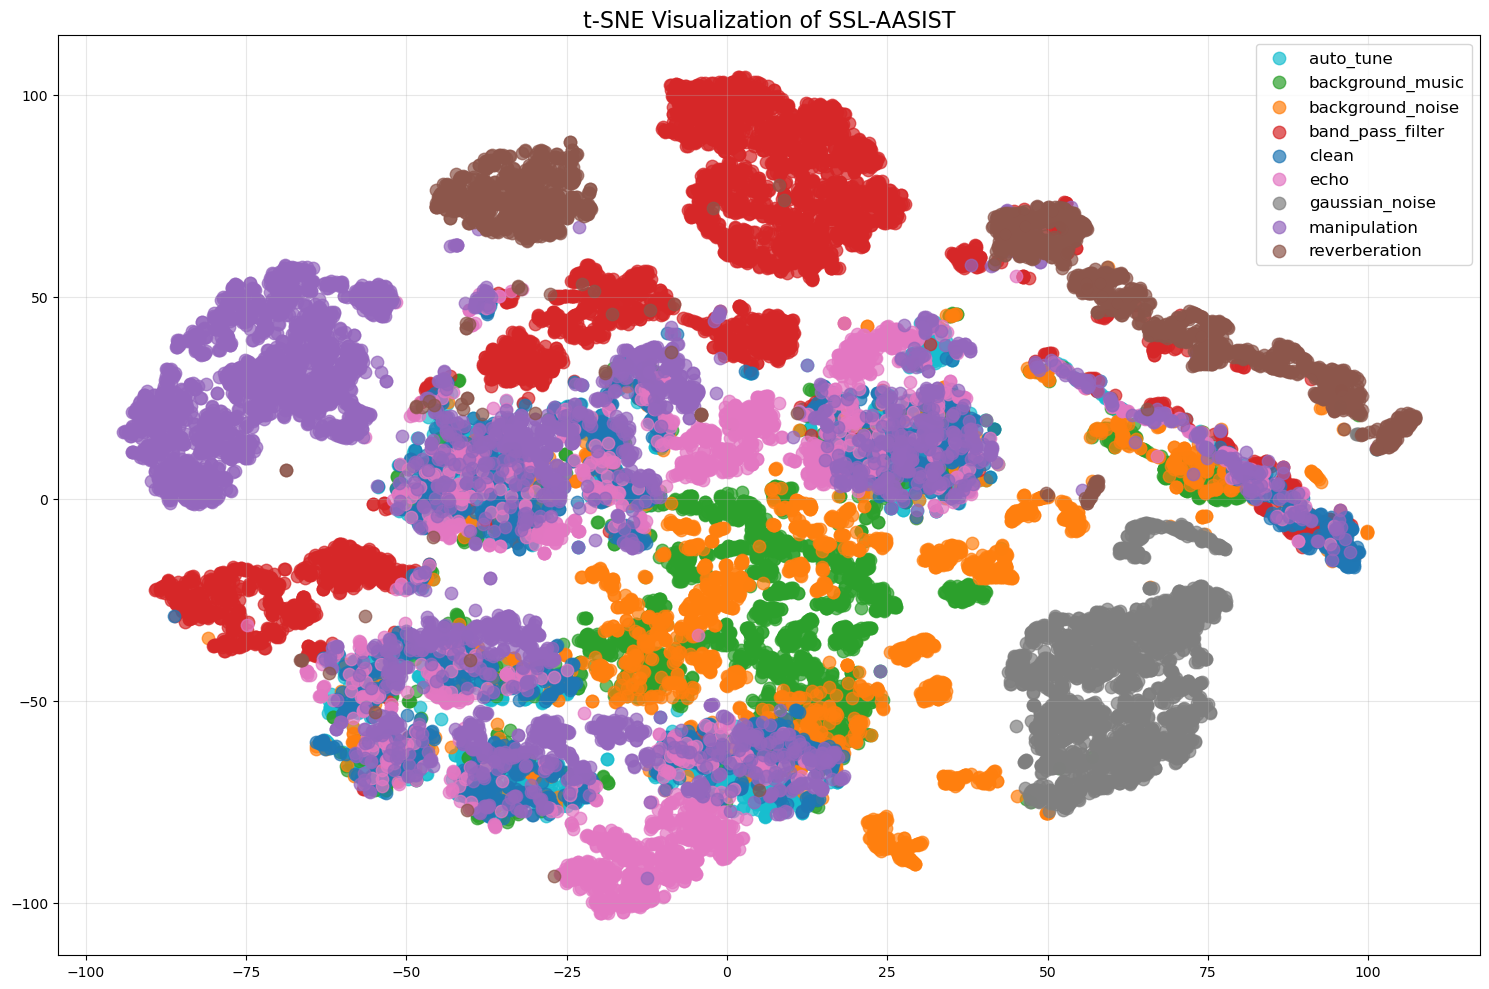

In [9]:
# Classes to visualize (we're handling potential naming variations in the function)
classes_to_show = ["clean","background_noise","background_music","band_pass_filter",
                   "manipulation","reverberation","echo","gaussian_noise","auto_tune"]
# Prepare the data
embeddings_list = [embeddings]  # Your embeddings variable
labels_list = [labels]  # Your labels variable
names_list = ['Audio Effects']  # Simplified name list

# Create the visualization
fig = visualize_filtered_embeddings(embeddings_list, labels_list, classes_to_show)

# Save the figure
plt.tight_layout()
plt.show()

### conformerTCM

In [3]:
asv19df = '/home/woongjae/noise-tracing/multi-feature_fusion/ICASSP2026/protocols/protocol_asv19.txt'
noisedf = '/home/woongjae/noise-tracing/multi-feature_fusion/ICASSP2026/protocols/NC_protocol.txt'

df1 = pd.read_csv(asv19df, sep=' ', header=None, names=['file_path', 'subset', 'noise_type'])

# 두 번째 파일 읽기
df2 = pd.read_csv(noisedf, sep=' ', header=None,
                  names=['id', 'file_path_full', 'label2', 'noise_type2', 'mode'])

# 두 번째 파일에서 file_path에서 접두사 제거
prefix = '/data/woongjae/preprocess/icassp/asv19/'
df2['file_path'] = df2['file_path_full'].str.replace(prefix, '', regex=False)

# 두 번째 파일에서 file_path, noise_type2 컬럼만 선택
df2_subset = df2[['file_path', 'noise_type2']]

# 두 데이터프레임을 file_path 기준으로 병합
df_merged = pd.merge(df1, df2_subset, on='file_path', how='left')

# noise_type2(두 번째파일 노이즈 타입) 병합 결과에 추가
df_merged['final_noise_type'] = df_merged['noise_type2'].combine_first(df_merged['noise_type'])

# 원하는 열만 추출
result = df_merged[['file_path', 'subset', 'final_noise_type']]
result['hash'] = result['file_path'].apply(lambda p: os.path.splitext(os.path.basename(p))[0])

# 결과 확인 및 저장
print(result.columns)
print(result.head())

Index(['file_path', 'subset', 'final_noise_type', 'hash'], dtype='object')
                                           file_path  subset  \
0                                          file_path  subset   
1  train/augmented/LA_T_7696598__background_music...   train   
2  train/augmented/LA_T_3458660__background_music...   train   
3  train/augmented/LA_T_4635249__background_music...   train   
4  train/augmented/LA_T_7676958__background_music...   train   

   final_noise_type                            hash  
0            label2                       file_path  
1  background_music  LA_T_7696598__background_music  
2  background_music  LA_T_3458660__background_music  
3  background_music  LA_T_4635249__background_music  
4  background_music  LA_T_7676958__background_music  


/tmp/ipykernel_2803266/1970574896.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['hash'] = result['file_path'].apply(lambda p: os.path.splitext(os.path.basename(p))[0])


In [4]:
# Load embeddings
# emb_path = "/data/woongjae/preprocess/embeddings/asv19/baseline"
emb_path = "/data/woongjae/preprocess/embeddings/conformertcm"

# emb 디렉토리의 .npy만 사용
file_list = [f for f in os.listdir(emb_path) if f.endswith('.npy')]

# Cell 3에서 만든 result 사용 (덮어쓰지 않음)
embeddings, labels = load_embeddings_v2(
    emb_path,
    file_list,
    result,                 # Cell 3의 result 사용
    query=None,
    num_workers=8,
    label_col="final_noise_type"   # Cell 3의 final_noise_type 컬럼 사용
)

Loading 24844 files after filtering.


Loading embeddings: 100%|██████████| 24844/24844 [05:24<00:00, 76.56it/s] 


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE  # Using sklearn's TSNE instead of tsnecuda for better compatibility
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
import os, pandas as pd
import random


np.random.seed(42)

def visualize_filtered_embeddings(embeddings_list, labels_list, classes_to_show):
    """
    Visualize only specific classes from embeddings using t-SNE in a single figure.
    
    Args:
        embeddings_list: List of embedding arrays
        labels_list: List of corresponding labels
        classes_to_show: List of class names to visualize
    """
    # Set up the figure
    plt.figure(figsize=(15, 10))
    
    # Color palette for the selected classes
    colors = {
        "clean":            "#1f77b4",  # 파랑
        "background_noise": "#ff7f0e",  # 주황
        "background_music": "#2ca02c",  # 초록
        "band_pass_filter": "#d62728",  # 빨강
        "manipulation":     "#9467bd",  # 보라
        "reverberation":    "#8c564b",  # 갈색
        "echo":             "#e377c2",  # 분홍
        "gaussian_noise":   "#7f7f7f",  # 회색
        "auto_tune":        "#17becf",  # 청록
    }
    random_colors = ["#FF5733", "#33FF57", "#3357FF", "#FF33A1", "#A133FF"]

    # Initialize lists to store filtered data
    all_tsne, all_labels = [], []
    
    # Process each embedding
    for idx, (embeddings, labels) in enumerate(
        tqdm(zip(embeddings_list, labels_list),
             total=len(embeddings_list), desc="Processing embeddings")):

        labels = np.array([str(l).lower() for l in labels])

        # 선택된 클래스만 필터링
        mask = np.isin(labels, classes_to_show)
        if not mask.any():
            continue

        filtered_embeddings = embeddings[mask]
        filtered_labels = labels[mask]

        if filtered_embeddings.ndim == 3:
            # 방법 1: 평균 풀링 (N, T, D) → (N, D)
            filtered_embeddings = filtered_embeddings.mean(axis=1)
        
        # 스케일링
        scaler = StandardScaler()
        embeddings_scaled = scaler.fit_transform(filtered_embeddings)

        # t-SNE
        tsne = TSNE(
            n_components=2,
            random_state=42,
            perplexity=min(30, len(filtered_embeddings) - 1),
            n_iter=1000,
            learning_rate='auto'
        )
        tsne_results = tsne.fit_transform(embeddings_scaled)

        all_tsne.append(tsne_results)
        all_labels.append(filtered_labels)

    if not all_tsne:
        raise ValueError("No matching classes found in the provided data.")

    combined_tsne = np.vstack(all_tsne)
    combined_labels = np.concatenate(all_labels)

    # 시각화
    for label in np.unique(combined_labels):
        mask = combined_labels == label
        plt.scatter(
            combined_tsne[mask, 0],
            combined_tsne[mask, 1],
            c=[colors.get(label, random.choice(random_colors))],
            label=label,
            alpha=0.7,
            s=80
        )

    plt.title('t-SNE Visualization of SSL-ConformerTCM', fontsize=16)
    plt.legend(
        loc='best',        # 가장 빈 공간을 자동으로 찾아줌
        fontsize=12,
        frameon=True       # 테두리 박스 넣으면 더 잘 보임
    )
    plt.grid(alpha=0.3)

    return plt.gcf()


# plt.savefig('filtered_embeddings_tsne_asv19_spoof.png', dpi=300, bbox_inches='tight')

Processing embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

/home/woongjae/miniconda3/envs/TSNE/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
Processing embeddings: 100%|██████████| 1/1 [06:55<00:00, 415.36s/it]


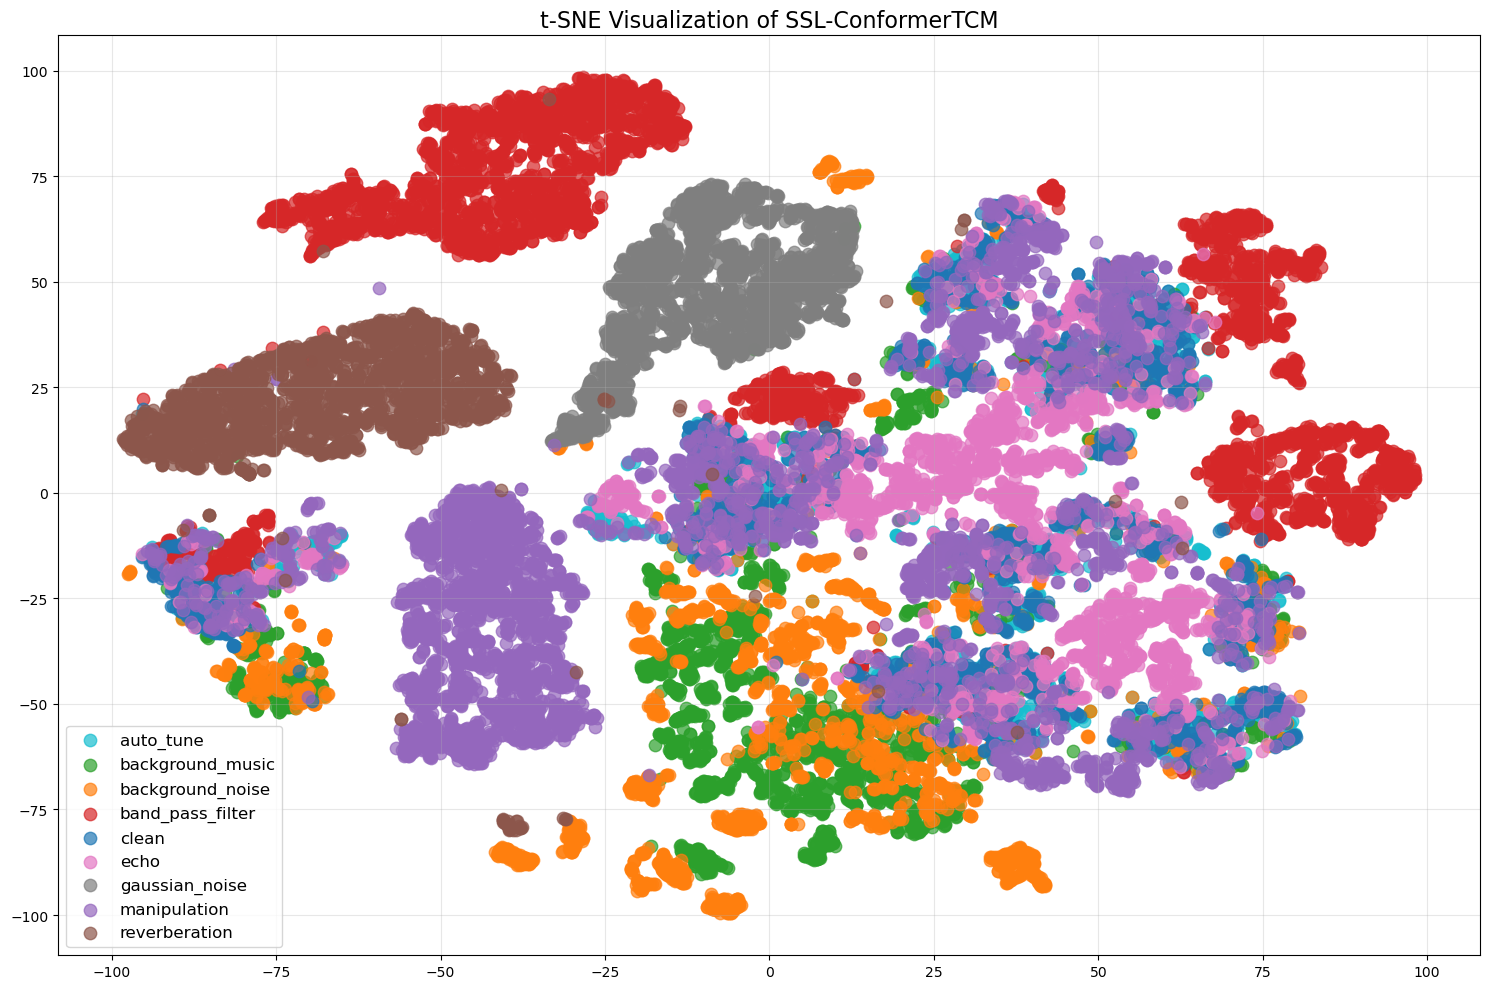

In [6]:
# Classes to visualize (we're handling potential naming variations in the function)
classes_to_show = ["clean","background_noise","background_music","band_pass_filter",
                   "manipulation","reverberation","echo","gaussian_noise","auto_tune"]
# Prepare the data
embeddings_list = [embeddings]  # Your embeddings variable
labels_list = [labels]  # Your labels variable
names_list = ['Audio Effects']  # Simplified name list

# Create the visualization
fig = visualize_filtered_embeddings(embeddings_list, labels_list, classes_to_show)

# Save the figure
plt.tight_layout()
plt.show()

# Spoof/bonafide

In [2]:
asv19df = '/home/woongjae/noise-tracing/multi-feature_fusion/ICASSP2026/protocols/noise_type_asv19/manipulation.txt'

df = pd.read_csv(asv19df, sep=' ', header=None, names=['file_path', 'subset', 'label'])

df['hash'] = df['file_path'].apply(lambda p: os.path.splitext(os.path.basename(p))[0])

# 결과 확인 및 저장
print(df.columns)
print(df.head())

Index(['file_path', 'subset', 'label', 'hash'], dtype='object')
                                       file_path subset  label  \
0  train/augmented/LA_T_5077542__pitch_shift.wav  train  spoof   
1  train/augmented/LA_T_7306687__pitch_shift.wav  train  spoof   
2  train/augmented/LA_T_3478545__pitch_shift.wav  train  spoof   
3  train/augmented/LA_T_9210982__pitch_shift.wav  train  spoof   
4  train/augmented/LA_T_7612854__pitch_shift.wav  train  spoof   

                        hash  
0  LA_T_5077542__pitch_shift  
1  LA_T_7306687__pitch_shift  
2  LA_T_3478545__pitch_shift  
3  LA_T_9210982__pitch_shift  
4  LA_T_7612854__pitch_shift  


In [3]:
# Load embeddings
emb_path = "/data/woongjae/preprocess/embeddings/g5/conformertcm/baseline"

# emb 디렉토리의 .npy만 사용
file_list = [f for f in os.listdir(emb_path) if f.endswith('.npy')]

# Cell 3에서 만든 result 사용 (덮어쓰지 않음)
embeddings, labels = load_embeddings_v2(
    emb_path,
    file_list,
    df,                 # Cell 3의 result 사용
    query=None,
    num_workers=8,
    label_col="label"   # Cell 3의 final_noise_type 컬럼 사용
)

Loading 4517 files after filtering.


Loading embeddings: 100%|██████████| 4517/4517 [00:03<00:00, 1470.89it/s] 


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE  # Using sklearn's TSNE instead of tsnecuda for better compatibility
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
import os, pandas as pd
import random


np.random.seed(42)

def visualize_filtered_embeddings(embeddings_list, labels_list, classes_to_show):
    """
    Visualize only specific classes from embeddings using t-SNE in a single figure.
    
    Args:
        embeddings_list: List of embedding arrays
        labels_list: List of corresponding labels
        classes_to_show: List of class names to visualize
    """
    # Set up the figure
    plt.figure(figsize=(5, 5))
    
    # Color palette for the selected classes
    colors = {
        "spoof":             "#e377c2",  # 분홍
        "bonafide":        "#17becf",  # 청록
    }
    random_colors = ["#FF5733", "#33FF57", "#3357FF", "#FF33A1", "#A133FF"]

    # Initialize lists to store filtered data
    all_tsne, all_labels = [], []
    
    # Process each embedding
    for idx, (embeddings, labels) in enumerate(
        tqdm(zip(embeddings_list, labels_list),
             total=len(embeddings_list), desc="Processing embeddings")):

        labels = np.array([str(l).lower() for l in labels])

        # 선택된 클래스만 필터링
        mask = np.isin(labels, classes_to_show)
        if not mask.any():
            continue

        filtered_embeddings = embeddings[mask]
        filtered_labels = labels[mask]

        if filtered_embeddings.ndim == 3:
            # 방법 1: 평균 풀링 (N, T, D) → (N, D)
            filtered_embeddings = filtered_embeddings.mean(axis=1)
        
        # 스케일링
        scaler = StandardScaler()
        embeddings_scaled = scaler.fit_transform(filtered_embeddings)

        # t-SNE
        tsne = TSNE(
            n_components=2,
            random_state=42,
            perplexity=min(30, len(filtered_embeddings) - 1),
            n_iter=1000,
            learning_rate='auto'
        )
        tsne_results = tsne.fit_transform(embeddings_scaled)

        all_tsne.append(tsne_results)
        all_labels.append(filtered_labels)

    if not all_tsne:
        raise ValueError("No matching classes found in the provided data.")

    combined_tsne = np.vstack(all_tsne)
    combined_labels = np.concatenate(all_labels)

    # 시각화
    for label in np.unique(combined_labels):
        mask = combined_labels == label
        marker = "o" if label == "bonafide" else "^"  # 마커 분리
        plt.scatter(
            combined_tsne[mask, 0],
            combined_tsne[mask, 1],
            c=[colors.get(label, random.choice(random_colors))],
            label=label,
            alpha=0.7,
            s=25,          # 점 크기 줄이기 (기존 80 → 25)
            marker=marker  # 클래스별 마커
        )

    # plt.title('t-SNE visualization of baseline', fontsize=16)
    # plt.legend(
    #     loc='best',        # 가장 빈 공간을 자동으로 찾아줌
    #     fontsize=12,
    #     frameon=True       # 테두리 박스 넣으면 더 잘 보임
    # )
    plt.grid(alpha=0.3)
    plt.xticks([])
    plt.yticks([])
    plt.savefig("conformertcm_baseline.pdf", format="pdf", bbox_inches="tight", dpi=400)
    return plt.gcf()


# plt.savefig('filtered_embeddings_tsne_asv19_spoof.png', dpi=300, bbox_inches='tight')

Processing embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/home/woongjae/miniconda3/envs/TSNE/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
Processing embeddings: 100%|██████████| 1/1 [00:06<00:00,  6.74s/it]


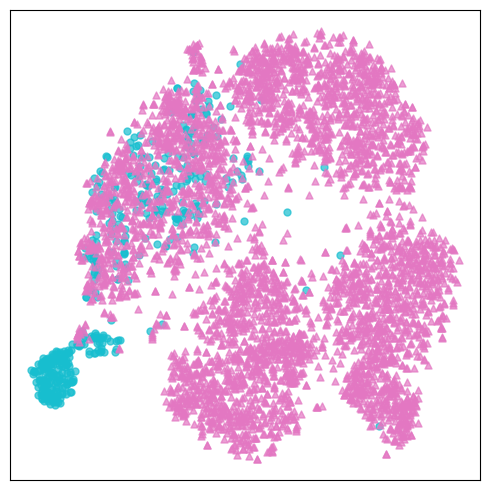

In [5]:
# Classes to visualize (we're handling potential naming variations in the function)
classes_to_show = ["spoof","bonafide"]
# Prepare the data
embeddings_list = [embeddings]  # Your embeddings variable
labels_list = [labels]  # Your labels variable
names_list = ['Audio Effects']  # Simplified name list

# Create the visualization
fig = visualize_filtered_embeddings(embeddings_list, labels_list, classes_to_show)

# Save the figure
plt.tight_layout()
plt.show()

In [3]:
import matplotlib.pyplot as plt

# legend 전용 figure
fig, ax = plt.subplots(figsize=(4, 0.6))  # ← 가로/세로 크기 직접 지정

# 더미 핸들 생성
p1 = ax.plot([], [], 'o', color='#17becf', label='bonafide')[0]
p2 = ax.plot([], [], '^', color='#e377c2', label='spoof')[0]

# legend만 저장
fig.legend(handles=[p1, p2], labels=['bonafide', 'spoof'],
           loc='center', ncol=2, frameon=False, fontsize=16)  # ← 폰트 크기 키움

ax.axis('off')  # 축 제거
plt.savefig("legend.pdf", format="pdf", bbox_inches="tight", dpi=400)
plt.close()
